# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Optimizing Self-Driving

Notebook 2 - Preprocessing & Modeling (part 1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import random
from os.path import exists
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
np.random.seed(42)
df = pd.read_csv('../data/merged_driving_log.csv')

### Image Augmentation

As discussed in the EDA section, there are a number of issues about our data that we need to address to improve their quality. We are hereby resort to image augmentation to achieve our goal. To be able to call the augmentation easily, we would create a function for each augmentation methods. The methods we will be using are as follows: 

- Cropping

  The images have irrelevant information such as sky and car front which do not help with the training. We therefore will cut them out.
  
- Resizing

  After cropping the images, we would resize them to match the input size of the network of 66x200 (details in notebook 3).

- Flipping

  To mitigate the bias in the direction of turning, we will flip the images horizontally to create a balanced training dataset.
  
- Random brightness (inspired by [Nick Condo](https://github.com/ncondo/CarND-Behavioral-Cloning)'s work)

  To ensure the data can be more generalized, we will randomly adjust the brightness of the images by converting the image to HSV color space and adjusting the V channel)
  
- Random Shadow (inspired by [Ujjwal Saxena](https://www.freecodecamp.org/news/image-augmentation-make-it-rain-make-it-snow-how-to-modify-a-photo-with-machine-learning-163c0cb3843f/)'s blog)

  Similar to the random brightness, adding random shadow to training data helps generalize the model under different lighting/weather conditions.
  
- Convert to YUV

  As suggested by NVIDIA model, we will also convert the image from RGB to YUV to feed the model.

In [3]:
# create the crop function

def crop(img):
    img = img[50:-25, :, :]
    return img

In [4]:
# new image size after resizing

new_height, new_width, new_channel = (66, 200, 3)

In [5]:
# create the resize function

def resize(img):
    img = cv2.resize(img, (new_width, new_height), cv2.INTER_AREA)
    return img

In [6]:
# create the flip function

def flip(img, angle):
    img = cv2.flip(img, 1)
    angle *= -1
    return (img, angle)

In [7]:
# create random brightness function
# credit: thanks to Nick Condo https://github.com/ncondo/CarND-Behavioral-Cloning/blob/master/model.py

def brightness(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # adjust saturation
    brightness = .25 + np.random.uniform()
    img[:, :, 2] = img[:, :, 2] * brightness
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

In [8]:
# create random brightness function
# credit: thanks to Naoki Shibuya https://github.com/naokishibuya/car-behavioral-cloning/blob/master/utils.py

def shadow(img):
    new_height, new_width, new_channel = (66, 200, 3)

    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    
    x1, y1 = new_width * np.random.rand(), 0
    x2, y2 = new_width * np.random.rand(), new_height
    xm, ym = np.mgrid[0: new_height, 0: new_width] 
    
    # to avoid zero-division problem, we'll write the line in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(img[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow
    cond = mask == np.random.randint(2)
   
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # adjust saturation
    shadow = np.random.uniform(low=0.2, high=0.5)
    img[:, :, 1][cond] = img[:, :, 1][cond] * shadow
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

In [9]:
# convert rgb to yuv 

def convert_yuv(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return img

In [10]:
# To combine some of the preprocessings together

def preprocessing(img): #, angle):
    img = crop(img)
    img = resize(img)
    img = brightness(img)
#    img = shadow(img)
#     img = flip(img, angle)
    img = convert_yuv(img)
    return img

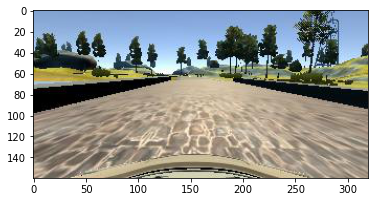

In [12]:
img = mpimg.imread('../data/'+df.center[0])
plt.imshow(img);

### Compile Training Data

In [12]:
def get_data(df):
    img, angle = [], []
    correction = 0.25
    for i in range(len(df.index)):
        df.iloc[i,3] = float(df.iloc[i, 3])
        img.append([df.iloc[i,0], df.iloc[i,1], df.iloc[i,2]])
        angle.append([df.iloc[i,3], df.iloc[i,3] + correction, df.iloc[i,3] - correction])
    return img, angle

In [13]:
# get our model features and target

X, y = get_data(df)

# shuffle the data to as the original are highly correlated 
X, y = shuffle(X, y, random_state = 42)

### Model Architecture

1. based on [NVIDIA](https://arxiv.org/pdf/1604.07316v1.pdf) model

<img src='../charts/cnn_architecture.png' style="float: left; width: 375px;"/>

### Without Batch Generator

In [14]:
new_height, new_width, new_channel = (66, 200, 3)
    
images = []
angles = []
straight_count = 0

for i in range(len(X)):
    # Select a random index to use for data sample
    sample_ids = random.randrange(len(X))
    image_ids = random.randrange(len(X[0]))
    angle = y[sample_ids][image_ids]
            
    # Limit angles of less than absolute value of .1 to no more than 1/2 of data
    # to reduce bias of car driving straig
    if abs(angle) < .15:
        straight_count += 1
    if straight_count > (len(X) * .5):
        while abs(y[sample_ids][image_ids]) < .15:
            sample_ids = random.randrange(len(X))
                    
    # Read image in from directory, process, and convert to numpy array
    if exists('../data/' + str(X[sample_ids][image_ids])):
        img = mpimg.imread('../data/' + str(X[sample_ids][image_ids]))
        img = preprocessing(img)
        img = np.asarray(img, dtype=np.float32)
    else:
        continue

#     # Flip image and apply opposite angle 50% of the time
#     if random.randrange(2) == 1:
#         img, angle = flip(img, angle)
    images.append(img)
    angles.append(angle)

In [15]:
X_new, y_new = images, angles
X_new = np.asarray(X_new)
y_new = np.asarray(y_new)

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new,
                                                                   random_state = 42)

In [16]:
model = Sequential()
model.add(Lambda(lambda x: (x / 127.5) - 1, input_shape=(66, 200, 3)))
model.add(Conv2D(24, (5, 5), activation="elu", strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation="elu", strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation="elu", strides=(2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation="elu"))
model.add(Conv2D(64, (3, 3), activation="elu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')


checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

model.fit(X_train_new, y_train_new,
          batch_size = 1,
          validation_data = (X_test_new, y_test_new),
          epochs = 20,
          verbose = 1,
          callbacks = [checkpoint])

model.save('../assets/model_no_gen.h5')
model.save('../assets/model_no_gen')

Epoch 1/20
6938/6938 [==============================] - 25s 4ms/step - loss: 153.4847 - val_loss: 0.0596
Epoch 2/20
6938/6938 [==============================] - 25s 4ms/step - loss: 0.0890 - val_loss: 0.1279
Epoch 3/20
6938/6938 [==============================] - 25s 4ms/step - loss: 0.1058 - val_loss: 0.0562
Epoch 4/20
6938/6938 [==============================] - 25s 4ms/step - loss: 1.2270 - val_loss: 0.2834
Epoch 5/20
6938/6938 [==============================] - 26s 4ms/step - loss: 0.0930 - val_loss: 0.1312
Epoch 6/20
6938/6938 [==============================] - 25s 4ms/step - loss: 0.0705 - val_loss: 0.0563
Epoch 7/20
6938/6938 [==============================] - 25s 4ms/step - loss: 0.0623 - val_loss: 0.0564
Epoch 8/20
6938/6938 [==============================] - 25s 4ms/step - loss: 0.0593 - val_loss: 0.0562
Epoch 9/20
6938/6938 [==============================] - 25s 4ms/step - loss: 0.0587 - val_loss: 0.0601
Epoch 10/20
6938/6938 [==============================] - 25s 4ms/step -

#### Takeaway: 

1. the smaller batch size, the better; 
2. epochs cannot exceed 20, otherwise the output doesn't change; 
3. model has hard time making big turns; best model lasts 26s on the track, run model_no_gen.h5; 
4. without flipping performs better than using flipping 
5. too many dropout layers cause very bad models

### Model Tuning - Transfer Learning

Converting the image data into arrays for modeling.

In [19]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 42)

In [17]:
# credit: https://github.com/ncondo/CarND-Behavioral-Cloning/blob/master/model.py

def generate_batch(X, y, batch_size = 64):
    
    new_height, new_width, new_channel = (66, 200, 3)
    
    images = np.zeros((batch_size, new_height, new_width, new_channel))
    angles = np.zeros((batch_size,))
    
    while True:
        
        straight_count = 0
        
        for i in range(batch_size):
            # Select a random index to use for data sample
            sample_ids = random.randrange(len(X))
            image_ids = random.randrange(len(X[0]))
            angle = y[sample_ids][image_ids]
            
            # Limit angles of less than absolute value of .1 to no more than 1/2 of data
            # to reduce bias of car driving straig
            if abs(angle) < .15:
                straight_count += 1
            if straight_count > (batch_size * .75):
                while abs(y[sample_ids][image_ids]) < .15:
                    sample_ids = random.randrange(len(X))
                    
            # Read image in from directory, process, and convert to numpy array
            if exists('../data/' + str(X[sample_ids][image_ids])):
                img = mpimg.imread('../data/' + str(X[sample_ids][image_ids]))
                img = preprocessing(img)
                img = np.asarray(img)
            else:
                continue

            # Flip image and apply opposite angle 50% of the time
            if random.randrange(2) == 1:
                img, angle = flip(img, angle)
            images[i] = img
            angles[i] = angle
        
        yield images, angles

In [52]:
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(66, 200, 3)))
model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')

es = EarlyStopping(patience = 5)

model.fit(x = generate_batch(X_train, y_train),
          steps_per_epoch = 20000,
          validation_data = generate_batch(X_test, y_test),
          validation_steps = len(X_test),
          epochs = 10,
          verbose = 1,
          callbacks = [es])

model.save('../assets/model.h5')
model.save('../assets/model')

Epoch 1/10
20000/20000 [==============================] - 2537s 127ms/step - loss: 0.0239 - val_loss: 0.0156
Epoch 2/10
20000/20000 [==============================] - 2633s 132ms/step - loss: 0.0188 - val_loss: 0.0154
Epoch 3/10
20000/20000 [==============================] - 2587s 129ms/step - loss: 0.0172 - val_loss: 0.0156
Epoch 4/10
20000/20000 [==============================] - 2742s 137ms/step - loss: 0.0162 - val_loss: 0.0146
Epoch 5/10
20000/20000 [==============================] - 2723s 136ms/step - loss: 0.0158 - val_loss: 0.0137
Epoch 6/10
20000/20000 [==============================] - 2727s 136ms/step - loss: 0.0154 - val_loss: 0.0150
Epoch 7/10
20000/20000 [==============================] - 2648s 132ms/step - loss: 0.0152 - val_loss: 0.0143
Epoch 8/10
20000/20000 [==============================] - 2615s 131ms/step - loss: 0.0150 - val_loss: 0.0145
Epoch 9/10
20000/20000 [==============================] - 2658s 133ms/step - loss: 0.0149 - val_loss: 0.0142
Epoch 10/10
20000/2

Performs very bad. Use model.h5 to see.

In [21]:
model = Sequential()
model.add(Lambda(lambda x: (x / 127.5) - 1, input_shape=(66, 200, 3)))
model.add(Conv2D(24, (5, 5), activation="elu", strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation="elu", strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation="elu", strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="elu"))
model.add(Conv2D(64, (3, 3), activation="elu"))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

model.fit(x = generate_batch(X_train, y_train),
          validation_data = generate_batch(X_test, y_test),
          steps_per_epoch = len(X_train)/64,
          validation_steps = len(X_test)/64,
          epochs = 20,
          verbose = 1,
          callbacks = [checkpoint])

# model.save('../assets/model_tune.h5')
model.save('../assets/model_tune')

Epoch 1/30
109/108 [==============================] - 18s 167ms/step - loss: 0.0559 - val_loss: 0.0366
Epoch 2/30
109/108 [==============================] - 18s 163ms/step - loss: 0.0384 - val_loss: 0.0339
Epoch 3/30
109/108 [==============================] - 18s 163ms/step - loss: 0.0361 - val_loss: 0.0282
Epoch 4/30
109/108 [==============================] - 18s 161ms/step - loss: 0.0318 - val_loss: 0.0287
Epoch 5/30
109/108 [==============================] - 18s 163ms/step - loss: 0.0323 - val_loss: 0.0284
Epoch 6/30
109/108 [==============================] - 18s 164ms/step - loss: 0.0313 - val_loss: 0.0256
Epoch 7/30
109/108 [==============================] - 18s 164ms/step - loss: 0.0303 - val_loss: 0.0283
Epoch 8/30
109/108 [==============================] - 18s 163ms/step - loss: 0.0297 - val_loss: 0.0264
Epoch 9/30
109/108 [==============================] - 18s 161ms/step - loss: 0.0333 - val_loss: 0.0291
Epoch 10/30
109/108 [==============================] - 18s 164ms/step - l

12 epochs perfomrs the best which lasted 16s on track however with big sway. 

#### Takeaway
1. models without batch generator perform better;
2. higher steps per epoch result in output not updating, didn't result in better performance
3. models that converge are not necessarily the best performing models
4. too many dropout layers hurt the model
5. lower mse doesn't mean better performance

### Further Tuning

In [11]:
def get_data_new(df):
    img, angle = [], []
    correction = 0.25
    for i in range(len(df.index)):
        df.iloc[i,3] = float(df.iloc[i, 3])
        img.append(df.iloc[i,0])
        img.append(df.iloc[i,1])
        img.append(df.iloc[i,2])
        angle.append(df.iloc[i,3])
        angle.append(df.iloc[i,3] + correction)
        angle.append(df.iloc[i,3] - correction)
    return img, angle

X, y = get_data_new(df)

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, random_state =42)

In [16]:
def generate(X, y, batch_size = 64):
    
    new_height, new_width, new_channel = (66, 200, 3)
    
    images = np.zeros((batch_size, new_height, new_width, new_channel))
    angles = np.zeros((batch_size,))
    
    while True:
        
        straight_count = 0
        
        for i in range(batch_size):
            # Select a random index to use for data sample
            ids = random.randrange(len(X))
            angle = y[ids]
            
            # Limit angles of less than absolute value of .1 to no more than 1/2 of data
            # to reduce bias of car driving straig
#             if abs(angle) < .15:
#                 straight_count += 1
#             if straight_count > (batch_size * .5):
#                 while abs(angle) < .15:
#                     ids = random.randrange(len(X))
                    
            # Read image in from directory, process, and convert to numpy array
            if exists('../data/' + str(X[ids])):
                img = mpimg.imread('../data/' + str(X[ids]))
                img = preprocessing(img)
                img = np.asarray(img)
            else:
                continue

            # Flip image and apply opposite angle 50% of the time
            if random.randrange(2) == 1:
                img, angle = flip(img, angle)
            images[i] = img
            angles[i] = angle
        
        yield images, angles

In [17]:
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(66, 200, 3)))
model.add(Conv2D(24, (5, 5), activation="elu", strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation="elu", strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation="elu", strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="elu"))
model.add(Conv2D(64, (3, 3), activation="elu"))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam')

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

model.fit(x = generate(X_tr, y_tr),
          steps_per_epoch = 20000,
          validation_data = generate(X_ts, y_ts),
          validation_steps = len(X_ts),
          epochs = 3,
          verbose = 1,
          callbacks = [checkpoint])

model.save('model_further.h5')
#model.save('model')

Epoch 1/3
20000/20000 [==============================] - 2632s 132ms/step - loss: 0.0152 - val_loss: 0.0131
Epoch 2/3
20000/20000 [==============================] - 2541s 127ms/step - loss: 0.0053 - val_loss: 0.0123
Epoch 3/3
20000/20000 [==============================] - 2430s 121ms/step - loss: 0.0038 - val_loss: 0.0120


In [18]:
model = Sequential()
model.add(Lambda(lambda x: (x / 127.5) - 1, input_shape=(66, 200, 3)))
model.add(Conv2D(24, (5, 5), activation="elu", strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation="elu", strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation="elu", strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="elu"))
model.add(Conv2D(64, (3, 3), activation="elu"))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss = 'huber', optimizer = 'adam')

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

model.fit(x = generate(X_tr, y_tr),
          steps_per_epoch = 20000,
          validation_data = generate(X_ts, y_ts),
          validation_steps = len(X_ts),
          epochs = 3,
          verbose = 1,
          callbacks = [checkpoint])

model.save('model_huber.h5')
#model.save('model')

Epoch 1/3
20000/20000 [==============================] - 2589s 129ms/step - loss: 0.0073 - val_loss: 0.0062
Epoch 2/3
20000/20000 [==============================] - 2638s 132ms/step - loss: 0.0025 - val_loss: 0.0060
Epoch 3/3
20000/20000 [==============================] - 2618s 131ms/step - loss: 0.0018 - val_loss: 0.0059


In [ ]:
def get_data_new(df):
    img, angle = [], []
    for i in range(len(df.index)):
        df.iloc[i,3] = float(df.iloc[i, 3])
        img.append(df.iloc[i,0])
        angle.append(df.iloc[i,3])
    return img, angle

X, y = get_data_new(df)

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, random_state =42)

In [ ]:
def generate(X, y, batch_size = 64):
    
    new_height, new_width, new_channel = (66, 200, 3)
    
    images = np.zeros((batch_size, new_height, new_width, new_channel))
    angles = np.zeros((batch_size,))
    
    while True:
        
#         straight_count = 0
        
        for i in range(batch_size):
            # Select a random index to use for data sample
            ids = random.randrange(len(X))
            angle = y[ids]
            
            # Limit angles of less than absolute value of .1 to no more than 1/2 of data
            # to reduce bias of car driving straig
#             if abs(angle) < .15:
#                 straight_count += 1
#             if straight_count > (batch_size * .5):
#                 while abs(angle) < .15:
#                     ids = random.randrange(len(X))
                    
            # Read image in from directory, process, and convert to numpy array
            if exists('../data/' + str(X[ids])):
                img = mpimg.imread('../data/' + str(X[ids]))
                img = preprocessing(img)
                img = np.asarray(img)
            else:
                continue

            # Flip image and apply opposite angle 50% of the time
            if random.randrange(2) == 1:
                img, angle = flip(img, angle)
            images[i] = img
            angles[i] = angle
        
        yield images, angles